In [ ]:
import os
import shutil
from os.path import join
import glob

In [ ]:
!unzip '/content/data.zip'

Archive:  /content/data.zip
   creating: test/
   creating: test/mask/
  inflating: test/mask/0_0_+·+ó 2020-02-24 172039.png  
  inflating: test/mask/0_0_+·+ó 2020-02-24 203708.png  
  inflating: test/mask/0_0_+·+ó 2020-02-24 203758.png  
  inflating: test/mask/0_0_+·+ó 2020-02-24 203844.png  
  inflating: test/mask/0_0_+·+ó 2020-02-24 205216.png  
  inflating: test/mask/0_0_+·+ó 2020-02-24 215615.png  
  inflating: test/mask/0_0_+·+ó 2020-02-24 222124.png  
  inflating: test/mask/0_0_+·+ó 2020-02-24 222132.png  
  inflating: test/mask/0_0_+·+ó 2020-02-24 225329.png  
  inflating: test/mask/0_0_+·+ó 2020-02-24 225408.png  
  inflating: test/mask/0_0_+·+ó 2020-02-24 225427.png  
  inflating: test/mask/0_0_+·+ó 2020-02-25 151936.png  
  inflating: test/mask/0_0_+·+ó 2020-02-25 185823.png  
  inflating: test/mask/0_0_+·+ó 2020-02-25 185912.png  
  inflating: test/mask/0_0_+·+ó 2020-02-25 190026.png  
  inflating: test/mask/0_0_0.jpeg    
  inflating: test/mask/0_0_0.png     
  inflating: 

In [ ]:
import tensorflow as tf
#DESIRED_ACCURACY = 0.99 #REQUIRED ACCURACY
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('accuracy')>0.99):
            print("\nReached 99.9% accuracy so cancelling training!")
            self.model.stop_training = True

In [ ]:
# labels and size of data
train_unmasked_fnames = os.listdir('/content/train/unmasked')
train_unmasked_fnames = ['unmasked' for x in train_unmasked_fnames]
train_mask_fnames = os.listdir('/content/train/mask')
train_mask_fnames = ['mask' for x in train_mask_fnames]
test_unmasked_fnames = os.listdir('/content/test/unmasked')
test_unmasked_fnames = ['unmasked' for x in test_unmasked_fnames]
test_mask_fnames = os.listdir('/content/test/mask')
test_mask_fnames = ['mask' for x in test_mask_fnames]
print(len(train_unmasked_fnames))
print(len(train_mask_fnames))
print(len(test_unmasked_fnames))
print(len(test_mask_fnames))

1003
1006
566
569


In [ ]:
# inception model with transfer learning
from tensorflow.keras.applications import InceptionV3

# Create an instance of the inception model from the local pre-trained weights
local_weights_file = '/content/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

pre_trained_model = InceptionV3(
    input_shape=(150, 150, 3),
    include_top=False,
    weights=None
)

pre_trained_model.load_weights(local_weights_file)

# Make all the layers in the pre-trained model non-trainable
for layer in pre_trained_model.layers:
  layer.trainable = False

# Print the model summary
pre_trained_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 74, 74, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 74, 74, 32)   0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [ ]:
last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 7, 7, 768)


In [ ]:
# transfer learning
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import layers
from tensorflow.keras import Model

# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)
# Add a dropout rate of 0.2
x = layers.Dropout(.5)(x)                  
# Add a final sigmoid layer for classification
x = layers.Dense(1, activation='sigmoid')(x)           

model = Model(pre_trained_model.input, x) 

model.compile(
    optimizer=RMSprop(lr=0.0001), 
    loss='binary_crossentropy', 
    metrics=['accuracy']
)

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 74, 74, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 74, 74, 32)   0           batch_normalization[0][0]        
____________________________________________________________________________________________

In [ ]:
#simple model
from tensorflow.keras.optimizers import RMSprop
model1 = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=(150,150,3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (2,2), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# from tensorflow.keras.optimizers import Adam
#from keras.optimizers import adam
# comp contains optimizer, loss function and metrics.
model1.compile(
    optimizer=RMSprop(lr=0.0001), 
    loss='binary_crossentropy', 
    metrics=['accuracy']
)
model1.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 148, 148, 64)      1792      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 74, 74, 64)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 72, 72, 64)        36928     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 35, 35, 32)        8224      
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 17, 17, 32)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 9248)             

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
train_dir = '/content/train' #path for train dir
test_dir = '/content/test'
train_datagen = ImageDataGenerator(
    rescale = 1./255.,
    rotation_range = 40,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True
)

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(
    rescale = 1./255.
)

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
    train_dir,
    batch_size=10,
    class_mode='binary',
    target_size=(150,150)
)     

# Flow validation images in batches of 20 using test_datagen generator
validation_generator =  test_datagen.flow_from_directory(
    test_dir,
    batch_size=10,
    class_mode='binary',
    target_size=(150,150)
)

Found 2009 images belonging to 2 classes.
Found 1135 images belonging to 2 classes.


In [ ]:
callbacks = myCallback()
history = model.fit_generator(
    train_generator,
    epochs=50,
    validation_data=validation_generator,
    callbacks=[callbacks]
)

Epoch 1/50
201/201 [==============================] - 17s 84ms/step - loss: 0.2548 - accuracy: 0.9014 - val_loss: 0.1230 - val_accuracy: 0.9568
Epoch 2/50
201/201 [==============================] - 16s 82ms/step - loss: 0.2098 - accuracy: 0.9149 - val_loss: 0.0943 - val_accuracy: 0.9709
Epoch 3/50
201/201 [==============================] - 16s 81ms/step - loss: 0.2026 - accuracy: 0.9253 - val_loss: 0.0775 - val_accuracy: 0.9780
Epoch 4/50
201/201 [==============================] - 16s 81ms/step - loss: 0.1740 - accuracy: 0.9343 - val_loss: 0.0967 - val_accuracy: 0.9648
Epoch 5/50
201/201 [==============================] - 16s 79ms/step - loss: 0.1580 - accuracy: 0.9413 - val_loss: 0.1804 - val_accuracy: 0.9348
Epoch 6/50
201/201 [==============================] - 16s 79ms/step - loss: 0.1805 - accuracy: 0.9373 - val_loss: 0.0582 - val_accuracy: 0.9841
Epoch 7/50
201/201 [==============================] - 16s 79ms/step - loss: 0.1490 - accuracy: 0.9487 - val_loss: 0.0541 - val_accuracy:

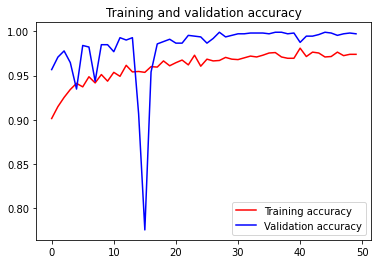

<Figure size 432x288 with 0 Axes>

In [ ]:
# Visulaize the results
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()

In [ ]:
# Test images 
from keras.preprocessing import image
import numpy as np
from PIL import *
#img_path = '/content/test/unmasked/0_0_aidai_0043.jpg'
img_path ='/content/test/mask/0_0_+·+ó 2020-02-24 203708.png'
image_size = 150
# test_image= image.load_img('/content/test/mask/0_0_+·+ó 2020-02-24 203708.png', target_size = (150, 150)) 
img = Image.open(img_path)
img = img.resize((image_size,image_size))
img = np.array(img)
img = img / 255.0
img = img.reshape(1,image_size,image_size,3)
img.shape
#round(model.predict(img).astype(int),1)
#model.predict_classes(img)
(model.predict(img) > 0.5).astype("int32")
#int(np.where(model.predict(img) > 0.5, 1, 0))
#.astype(int)
# result = 
#pred = model.predict(img) 
#tf.keras.np_utils.probas_to_classes(pred)
#print(pred)

array([[0]], dtype=int32)

In [ ]:
#labels_dict={0:'mask',1:'unmasked'} 


In [ ]:
from keras.models import load_model

model.save('/content/simplemaskdetectionmodel.h5')